# Petroglyphs Segmentation Model - Notebook

### Using a Custom Dice Loss class



$\text{Given a predicted mask }  p \text{ and the ground truth target } t, \text{ with a smoothing factor } s, \text{ the Dice Loss } L \text{ is defined as:}$

#### $L = 1 - \frac{2 \cdot \sum(p \cdot t) + s}{\sum(p^{2}) + \sum(t^{2}) + s}$

The smoothing factor is a very small number added to avoid division by 0. Read more about Dice Loss [here](https://arxiv.org/pdf/1606.04797.pdf) (on page 6).

In [1]:

import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, prediction, target, smooth=1e-6):

        prediction_flat = prediction.view(-1)
        target_flat = target.view(-1)
        
        intersection = (prediction_flat * target_flat).sum()
        dice_coefficient = (2. * intersection + smooth) / (prediction_flat.pow(2).sum() + target_flat.pow(2).sum() + smooth)
        dice_loss = 1 - dice_coefficient
        return  dice_loss
    
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2, logits=False):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
    def forward(self, inputs, targets):
        loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        pt = torch.exp(-1 * loss)
        f_loss = self.alpha * (1 - pt) ** self.gamma * loss
        return torch.mean(f_loss)

dice = DiceLoss()
focal = FocalLoss()

def loss_fn(inputs, targets, weights=[0.85, 0.15]):
    return weights[0] * dice(inputs, targets) + weights[1] * focal(inputs, targets)

## Loading Data into Dataloaders

In [2]:
# Define transforms for images and masks
transform_img = transforms.Compose([
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform_mask = transforms.Compose([
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
])

# Custom Dataset class to preload images and masks into memory
class PreloadedDataset(Dataset):
    def __init__(self, root_dir, transform_img, transform_mask):
        self.root_dir = root_dir
        self.image_files = sorted(os.listdir(os.path.join(root_dir, 'images')))
        self.mask_files = sorted(os.listdir(os.path.join(root_dir, 'masks')))
        self.images = []
        self.masks = []
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self._preload_data()

    def _preload_data(self):
        for image_file, mask_file in tqdm(
                zip(self.image_files, self.mask_files),
                total=len(self.image_files),
                desc='Loading data into memory'
            ):
            image_path = os.path.join(self.root_dir, 'images', image_file)
            mask_path = os.path.join(self.root_dir, 'masks', mask_file)
            image = Image.open(image_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
            if True:
                image = self.transform_img(image)
                mask = self.transform_mask(mask)
                mask = (mask >= 0.5).float()
            self.images.append(image)
            self.masks.append(mask)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]

dataset = PreloadedDataset(
    root_dir='D:/ubaid',
    transform_img=transform_img,
    transform_mask=transform_mask
    )

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
b = 10
train_dataloader = DataLoader(train_dataset, batch_size=b, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=b)



Loading data into memory:   0%|          | 0/234 [00:00<?, ?it/s]

Loading data into memory: 100%|██████████| 234/234 [00:31<00:00,  7.31it/s]


In [3]:
model = models.segmentation.lraspp_mobilenet_v3_large(weights=models.segmentation.LRASPP_MobileNet_V3_Large_Weights.DEFAULT)

model.classifier.low_classifier = nn.Conv2d(40, 1, 1, 1)
model.classifier.high_classifier = nn.Sequential(
    nn.Conv2d(128, 1, 1, 1),
    nn.Sigmoid()
)

In [4]:

# model = models.segmentation.deeplabv3_resnet50(weights = models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)

# # Modify last layer for binary segmentation
# num_classes = 1
# model.classifier[4] = nn.Sequential(
#     nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1)),
#     nn.Sigmoid()
#     )

criterion = loss_fn
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=0.01)

## Training Loop

In [5]:
best_val_loss = 999999
best_model_state = None

# Training loop
num_epochs = 100
model.to(device)
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_dataloader, desc=f'Epoch {epoch+1}'):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_dataset)
    
    # Validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss}, Val Loss: {val_loss}')
    
    # Update best validation loss and save the corresponding model state
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

# Save the model with the best validation loss
torch.save(best_model_state, 'lrs_expfocal_best_val_loss.pth')
model.load_state_dict(best_model_state)


Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s]C:\Users\Umar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Epoch 1: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]


Epoch [1/100], Train Loss: 0.4672520047142392, Val Loss: 0.39631071438392


Epoch 2: 100%|██████████| 21/21 [00:04<00:00,  4.51it/s]


Epoch [2/100], Train Loss: 0.31608010047958013, Val Loss: 0.24050511419773102


Epoch 3: 100%|██████████| 21/21 [00:04<00:00,  4.49it/s]


Epoch [3/100], Train Loss: 0.2439612206958589, Val Loss: 0.2007620632648468


Epoch 4: 100%|██████████| 21/21 [00:04<00:00,  4.43it/s]


Epoch [4/100], Train Loss: 0.2027611689908164, Val Loss: 0.16900479172666868


Epoch 5: 100%|██████████| 21/21 [00:04<00:00,  4.46it/s]


Epoch [5/100], Train Loss: 0.17968462052799405, Val Loss: 0.15396761894226074


Epoch 6: 100%|██████████| 21/21 [00:04<00:00,  4.45it/s]


Epoch [6/100], Train Loss: 0.1666788856188456, Val Loss: 0.14546985551714897


Epoch 7: 100%|██████████| 21/21 [00:04<00:00,  4.44it/s]


Epoch [7/100], Train Loss: 0.15042715200356074, Val Loss: 0.13947450493772826


Epoch 8: 100%|██████████| 21/21 [00:04<00:00,  4.41it/s]


Epoch [8/100], Train Loss: 0.14059666153930483, Val Loss: 0.13352584838867188


Epoch 9: 100%|██████████| 21/21 [00:04<00:00,  4.42it/s]


Epoch [9/100], Train Loss: 0.13766927626870928, Val Loss: 0.1317432721455892


Epoch 10: 100%|██████████| 21/21 [00:04<00:00,  4.35it/s]


Epoch [10/100], Train Loss: 0.1303467700878779, Val Loss: 0.12467481320103009


Epoch 11: 100%|██████████| 21/21 [00:04<00:00,  4.34it/s]


Epoch [11/100], Train Loss: 0.12589054022516524, Val Loss: 0.1191411471615235


Epoch 12: 100%|██████████| 21/21 [00:04<00:00,  4.42it/s]


Epoch [12/100], Train Loss: 0.11910843529871531, Val Loss: 0.12021011114120483


Epoch 13: 100%|██████████| 21/21 [00:04<00:00,  4.33it/s]


Epoch [13/100], Train Loss: 0.11856680256979805, Val Loss: 0.11785538929204147


Epoch 14: 100%|██████████| 21/21 [00:04<00:00,  4.25it/s]


Epoch [14/100], Train Loss: 0.11078463352861859, Val Loss: 0.11606158502399921


Epoch 15: 100%|██████████| 21/21 [00:04<00:00,  4.27it/s]


Epoch [15/100], Train Loss: 0.10846719429606483, Val Loss: 0.11140091406802337


Epoch 16: 100%|██████████| 21/21 [00:04<00:00,  4.22it/s]


Epoch [16/100], Train Loss: 0.10920387754837672, Val Loss: 0.10969540166358153


Epoch 17: 100%|██████████| 21/21 [00:05<00:00,  4.16it/s]


Epoch [17/100], Train Loss: 0.10431953484103793, Val Loss: 0.10971567966043949


Epoch 18: 100%|██████████| 21/21 [00:05<00:00,  4.01it/s]


Epoch [18/100], Train Loss: 0.10135512657108761, Val Loss: 0.11185189212361972


Epoch 19: 100%|██████████| 21/21 [00:05<00:00,  4.19it/s]


Epoch [19/100], Train Loss: 0.09855927526950836, Val Loss: 0.10849510009090106


Epoch 20: 100%|██████████| 21/21 [00:05<00:00,  4.13it/s]


Epoch [20/100], Train Loss: 0.09698809009222757, Val Loss: 0.10639405623078346


Epoch 21: 100%|██████████| 21/21 [00:04<00:00,  4.23it/s]


Epoch [21/100], Train Loss: 0.0946066276658149, Val Loss: 0.10218604902426402


Epoch 22: 100%|██████████| 21/21 [00:04<00:00,  4.21it/s]


Epoch [22/100], Train Loss: 0.09351537092810586, Val Loss: 0.10413755973180135


Epoch 23: 100%|██████████| 21/21 [00:05<00:00,  4.09it/s]


Epoch [23/100], Train Loss: 0.09384019389038994, Val Loss: 0.10176252201199532


Epoch 24: 100%|██████████| 21/21 [00:05<00:00,  4.19it/s]


Epoch [24/100], Train Loss: 0.09311845934107191, Val Loss: 0.10437065611282985


Epoch 25: 100%|██████████| 21/21 [00:05<00:00,  4.15it/s]


Epoch [25/100], Train Loss: 0.0911055285306204, Val Loss: 0.10134532364706199


Epoch 26: 100%|██████████| 21/21 [00:05<00:00,  4.08it/s]


Epoch [26/100], Train Loss: 0.08968590448300044, Val Loss: 0.1017091100414594


Epoch 27: 100%|██████████| 21/21 [00:05<00:00,  4.16it/s]


Epoch [27/100], Train Loss: 0.08835986327557337, Val Loss: 0.09948810127874215


Epoch 28: 100%|██████████| 21/21 [00:05<00:00,  4.19it/s]


Epoch [28/100], Train Loss: 0.0855433511592093, Val Loss: 0.10162019543349743


Epoch 29: 100%|██████████| 21/21 [00:05<00:00,  4.08it/s]


Epoch [29/100], Train Loss: 0.08316663439784731, Val Loss: 0.10197695530951023


Epoch 30: 100%|██████████| 21/21 [00:05<00:00,  4.02it/s]


Epoch [30/100], Train Loss: 0.08287816991408666, Val Loss: 0.09995626161495845


Epoch 31: 100%|██████████| 21/21 [00:05<00:00,  4.12it/s]


Epoch [31/100], Train Loss: 0.08171598293951579, Val Loss: 0.10024672995011012


Epoch 32: 100%|██████████| 21/21 [00:05<00:00,  3.99it/s]


Epoch [32/100], Train Loss: 0.0821371961917196, Val Loss: 0.10140385230382283


Epoch 33: 100%|██████████| 21/21 [00:05<00:00,  4.17it/s]


Epoch [33/100], Train Loss: 0.07950612228541147, Val Loss: 0.10156037844717503


Epoch 34: 100%|██████████| 21/21 [00:05<00:00,  4.17it/s]


Epoch [34/100], Train Loss: 0.07793720900302842, Val Loss: 0.10072142568727334


Epoch 35: 100%|██████████| 21/21 [00:05<00:00,  4.10it/s]


Epoch [35/100], Train Loss: 0.0795263069726172, Val Loss: 0.0989815437545379


Epoch 36: 100%|██████████| 21/21 [00:05<00:00,  4.15it/s]


Epoch [36/100], Train Loss: 0.07934343601976122, Val Loss: 0.09941963789363702


Epoch 37: 100%|██████████| 21/21 [00:05<00:00,  4.17it/s]


Epoch [37/100], Train Loss: 0.07855476527696564, Val Loss: 0.10049480199813843


Epoch 38: 100%|██████████| 21/21 [00:05<00:00,  4.09it/s]


Epoch [38/100], Train Loss: 0.07495549640485219, Val Loss: 0.09837071845928828


Epoch 39: 100%|██████████| 21/21 [00:05<00:00,  4.12it/s]


Epoch [39/100], Train Loss: 0.07528783859951156, Val Loss: 0.09773007283608119


Epoch 40: 100%|██████████| 21/21 [00:05<00:00,  4.14it/s]


Epoch [40/100], Train Loss: 0.075104045016425, Val Loss: 0.1001730418453614


Epoch 41: 100%|██████████| 21/21 [00:05<00:00,  4.07it/s]


Epoch [41/100], Train Loss: 0.07393961985196386, Val Loss: 0.09933077978591125


Epoch 42: 100%|██████████| 21/21 [00:05<00:00,  4.11it/s]


Epoch [42/100], Train Loss: 0.07198677673226311, Val Loss: 0.09813207263747852


Epoch 43: 100%|██████████| 21/21 [00:05<00:00,  4.15it/s]


Epoch [43/100], Train Loss: 0.07189429303010304, Val Loss: 0.09906071983277798


Epoch 44: 100%|██████████| 21/21 [00:05<00:00,  4.10it/s]


Epoch [44/100], Train Loss: 0.0715666189789772, Val Loss: 0.09641495657463868


Epoch 45: 100%|██████████| 21/21 [00:05<00:00,  4.11it/s]


Epoch [45/100], Train Loss: 0.07187115170416378, Val Loss: 0.10093878706296285


Epoch 46: 100%|██████████| 21/21 [00:05<00:00,  4.12it/s]


Epoch [46/100], Train Loss: 0.06995834605324835, Val Loss: 0.09767527009050052


Epoch 47: 100%|██████████| 21/21 [00:05<00:00,  4.10it/s]


Epoch [47/100], Train Loss: 0.069693400036721, Val Loss: 0.09853772260248661


Epoch 48: 100%|██████████| 21/21 [00:05<00:00,  4.10it/s]


Epoch [48/100], Train Loss: 0.06916953321723711, Val Loss: 0.09838779519001643


Epoch 49: 100%|██████████| 21/21 [00:05<00:00,  4.13it/s]


Epoch [49/100], Train Loss: 0.06802754175095331, Val Loss: 0.09772777433196704


Epoch 50: 100%|██████████| 21/21 [00:05<00:00,  4.05it/s]


Epoch [50/100], Train Loss: 0.06865391241652626, Val Loss: 0.09561335481703281


Epoch 51: 100%|██████████| 21/21 [00:05<00:00,  4.11it/s]


Epoch [51/100], Train Loss: 0.06782038971072152, Val Loss: 0.09718597990771134


Epoch 52: 100%|██████████| 21/21 [00:05<00:00,  4.13it/s]


Epoch [52/100], Train Loss: 0.06778166425370034, Val Loss: 0.09548983971277873


Epoch 53: 100%|██████████| 21/21 [00:05<00:00,  3.98it/s]


Epoch [53/100], Train Loss: 0.06680792357240405, Val Loss: 0.10026171741386254


Epoch 54: 100%|██████████| 21/21 [00:05<00:00,  4.07it/s]


Epoch [54/100], Train Loss: 0.06614843596305166, Val Loss: 0.09718636982142925


Epoch 55: 100%|██████████| 21/21 [00:05<00:00,  4.07it/s]


Epoch [55/100], Train Loss: 0.06598325534945443, Val Loss: 0.0975062573949496


Epoch 56: 100%|██████████| 21/21 [00:05<00:00,  4.03it/s]


Epoch [56/100], Train Loss: 0.06598026181260745, Val Loss: 0.09701859205961227


Epoch 57: 100%|██████████| 21/21 [00:05<00:00,  4.05it/s]


Epoch [57/100], Train Loss: 0.06500201246568135, Val Loss: 0.09747614649434884


Epoch 58: 100%|██████████| 21/21 [00:05<00:00,  4.11it/s]


Epoch [58/100], Train Loss: 0.0640401653945446, Val Loss: 0.09688526205718517


Epoch 59: 100%|██████████| 21/21 [00:05<00:00,  3.99it/s]


Epoch [59/100], Train Loss: 0.06331438500256766, Val Loss: 0.09614608685175578


Epoch 60: 100%|██████████| 21/21 [00:05<00:00,  4.06it/s]


Epoch [60/100], Train Loss: 0.06342140283612978, Val Loss: 0.09671792574226856


Epoch 61: 100%|██████████| 21/21 [00:05<00:00,  4.11it/s]


Epoch [61/100], Train Loss: 0.06414160912945158, Val Loss: 0.09732199149827163


Epoch 62: 100%|██████████| 21/21 [00:05<00:00,  4.01it/s]


Epoch [62/100], Train Loss: 0.06320147553370112, Val Loss: 0.09600897692143917


Epoch 63: 100%|██████████| 21/21 [00:05<00:00,  4.04it/s]


Epoch [63/100], Train Loss: 0.06299904804854166, Val Loss: 0.09603613490859668


Epoch 64: 100%|██████████| 21/21 [00:05<00:00,  4.09it/s]


Epoch [64/100], Train Loss: 0.06447528001098406, Val Loss: 0.09785945837696393


Epoch 65: 100%|██████████| 21/21 [00:05<00:00,  3.91it/s]


Epoch [65/100], Train Loss: 0.06454685206214587, Val Loss: 0.09800129197537899


Epoch 66: 100%|██████████| 21/21 [00:05<00:00,  4.08it/s]


Epoch [66/100], Train Loss: 0.06329379319435074, Val Loss: 0.09770469553768635


Epoch 67: 100%|██████████| 21/21 [00:05<00:00,  4.06it/s]


Epoch [67/100], Train Loss: 0.06228967844730332, Val Loss: 0.09544842752317588


Epoch 68: 100%|██████████| 21/21 [00:05<00:00,  3.99it/s]


Epoch [68/100], Train Loss: 0.06128606413091932, Val Loss: 0.09588414803147316


Epoch 69: 100%|██████████| 21/21 [00:05<00:00,  4.00it/s]


Epoch [69/100], Train Loss: 0.060759092548063824, Val Loss: 0.09546652374168237


Epoch 70: 100%|██████████| 21/21 [00:05<00:00,  4.03it/s]


Epoch [70/100], Train Loss: 0.06213875310052009, Val Loss: 0.09694783079127471


Epoch 71: 100%|██████████| 21/21 [00:05<00:00,  3.94it/s]


Epoch [71/100], Train Loss: 0.0609677384297053, Val Loss: 0.09599570247034232


Epoch 72: 100%|██████████| 21/21 [00:05<00:00,  4.05it/s]


Epoch [72/100], Train Loss: 0.06028286704704875, Val Loss: 0.09628052574892838


Epoch 73: 100%|██████████| 21/21 [00:05<00:00,  3.97it/s]


Epoch [73/100], Train Loss: 0.060477279304038914, Val Loss: 0.09679391669730346


Epoch 74: 100%|██████████| 21/21 [00:05<00:00,  3.87it/s]


Epoch [74/100], Train Loss: 0.0597336379190286, Val Loss: 0.09662701686223348


Epoch 75: 100%|██████████| 21/21 [00:05<00:00,  4.05it/s]


Epoch [75/100], Train Loss: 0.05974581482864562, Val Loss: 0.09630484568576018


Epoch 76: 100%|██████████| 21/21 [00:05<00:00,  3.94it/s]


Epoch [76/100], Train Loss: 0.060009337606884185, Val Loss: 0.09753925415376823


Epoch 77: 100%|██████████| 21/21 [00:05<00:00,  3.97it/s]


Epoch [77/100], Train Loss: 0.05934485668937365, Val Loss: 0.0966602669407924


Epoch 78: 100%|██████████| 21/21 [00:05<00:00,  4.05it/s]


Epoch [78/100], Train Loss: 0.05914136306160972, Val Loss: 0.09555946476757526


Epoch 79: 100%|██████████| 21/21 [00:05<00:00,  4.07it/s]


Epoch [79/100], Train Loss: 0.05828956958083879, Val Loss: 0.09575123215715091


Epoch 80: 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]


Epoch [80/100], Train Loss: 0.059658478058519815, Val Loss: 0.09559889882802963


Epoch 81: 100%|██████████| 21/21 [00:05<00:00,  4.04it/s]


Epoch [81/100], Train Loss: 0.05892160180069152, Val Loss: 0.0970693485190471


Epoch 82: 100%|██████████| 21/21 [00:05<00:00,  3.98it/s]


Epoch [82/100], Train Loss: 0.05796891912108376, Val Loss: 0.09765717200934887


Epoch 83: 100%|██████████| 21/21 [00:05<00:00,  3.99it/s]


Epoch [83/100], Train Loss: 0.058896199046146305, Val Loss: 0.09782074702282746


Epoch 84: 100%|██████████| 21/21 [00:05<00:00,  4.02it/s]


Epoch [84/100], Train Loss: 0.05802931831706138, Val Loss: 0.0970778161038955


Epoch 85: 100%|██████████| 21/21 [00:05<00:00,  3.96it/s]


Epoch [85/100], Train Loss: 0.05726231031474613, Val Loss: 0.09782443940639496


Epoch 86: 100%|██████████| 21/21 [00:05<00:00,  3.97it/s]


Epoch [86/100], Train Loss: 0.057358025440147946, Val Loss: 0.09681498445570469


Epoch 87: 100%|██████████| 21/21 [00:05<00:00,  4.04it/s]


Epoch [87/100], Train Loss: 0.05830503751834234, Val Loss: 0.10116466755668323


Epoch 88: 100%|██████████| 21/21 [00:05<00:00,  4.00it/s]


Epoch [88/100], Train Loss: 0.05829419940710068, Val Loss: 0.09709842254718144


Epoch 89: 100%|██████████| 21/21 [00:05<00:00,  3.99it/s]


Epoch [89/100], Train Loss: 0.058512753673962185, Val Loss: 0.09667270195980866


Epoch 90: 100%|██████████| 21/21 [00:05<00:00,  4.05it/s]


Epoch [90/100], Train Loss: 0.05680568161464873, Val Loss: 0.09613809362053871


Epoch 91: 100%|██████████| 21/21 [00:05<00:00,  3.95it/s]


Epoch [91/100], Train Loss: 0.05792585973228727, Val Loss: 0.09644265907506148


Epoch 92: 100%|██████████| 21/21 [00:05<00:00,  3.95it/s]


Epoch [92/100], Train Loss: 0.05654975825122425, Val Loss: 0.0967406394581


Epoch 93: 100%|██████████| 21/21 [00:05<00:00,  4.02it/s]


Epoch [93/100], Train Loss: 0.056218554576238, Val Loss: 0.09643916847805183


Epoch 94: 100%|██████████| 21/21 [00:05<00:00,  3.92it/s]


Epoch [94/100], Train Loss: 0.05705133346574647, Val Loss: 0.09664818023641904


Epoch 95: 100%|██████████| 21/21 [00:05<00:00,  3.98it/s]


Epoch [95/100], Train Loss: 0.05707553561244692, Val Loss: 0.09625219615797202


Epoch 96: 100%|██████████| 21/21 [00:05<00:00,  4.03it/s]


Epoch [96/100], Train Loss: 0.05724485679751351, Val Loss: 0.0951804139961799


Epoch 97: 100%|██████████| 21/21 [00:05<00:00,  3.54it/s]


Epoch [97/100], Train Loss: 0.057024261426358, Val Loss: 0.0959763452410698


Epoch 98: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]


Epoch [98/100], Train Loss: 0.057052411671195714, Val Loss: 0.09595961372057597


Epoch 99: 100%|██████████| 21/21 [00:05<00:00,  3.80it/s]


Epoch [99/100], Train Loss: 0.05642511766581308, Val Loss: 0.09652195932964484


Epoch 100: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]


Epoch [100/100], Train Loss: 0.056284445382299875, Val Loss: 0.09719675530989964


<All keys matched successfully>

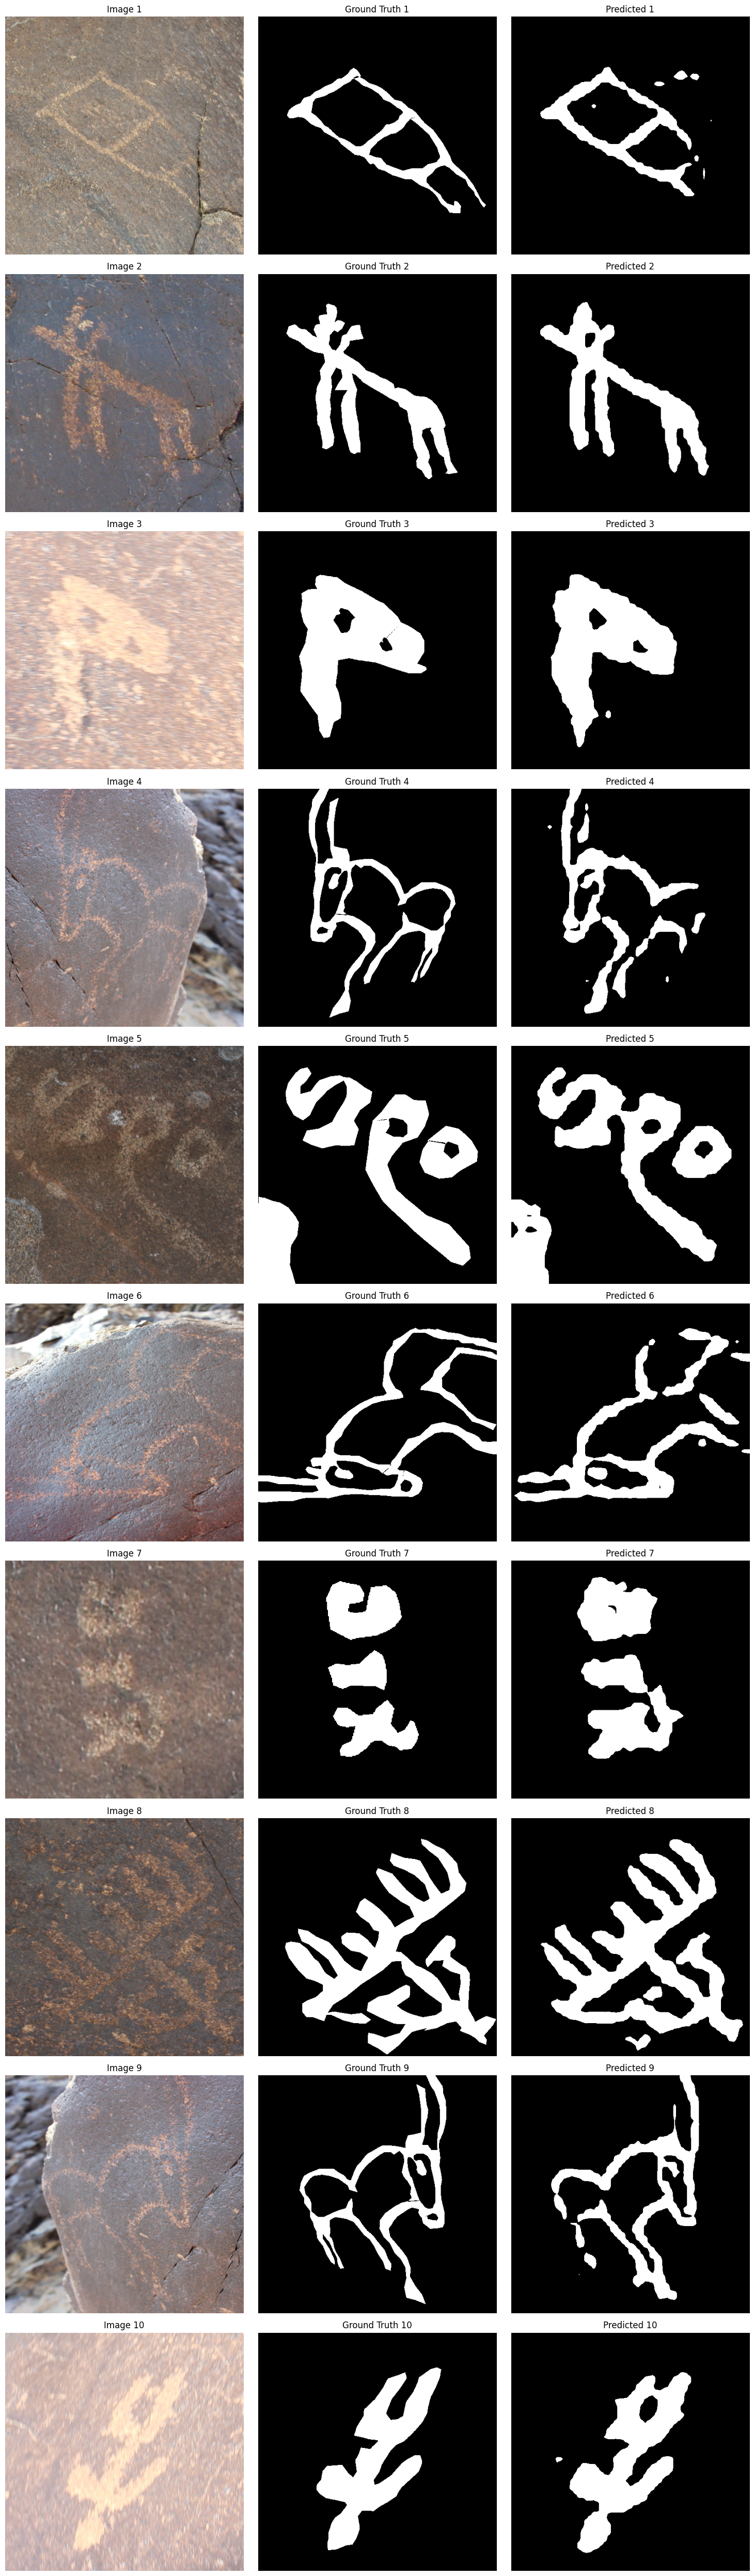

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the denormalization transform
denormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# Function to visualize images and masks in a grid
def visualize_predictions_grid(model, dataloader, num_samples=10):
    model.eval()
    samples = np.random.choice(len(dataloader.dataset), num_samples, replace=False)

    total_rows = num_samples
    cols_per_sample = 3
    plt.figure(figsize=(cols_per_sample * 5, total_rows * 5))
    
    with torch.no_grad():
        for i, idx in enumerate(samples):
            image, mask = dataloader.dataset[idx]
            image = image.unsqueeze(0).cuda()
            mask = mask.unsqueeze(0)
            output = model(image)['out'] >= 0.5 # defined the threshold at 0.5, can experiment with different values
            pred_mask = output.squeeze().cpu().numpy()

            # Denormalize the image for visualization
            image_denorm = denormalize(image.squeeze().cpu())
            image_denorm = torch.clamp(image_denorm, 0, 1)  # Ensure the values are in the range [0, 1]
            image_denorm = transforms.ToPILImage()(image_denorm)

            plt.subplot(total_rows, cols_per_sample, i * cols_per_sample + 1)
            plt.imshow(image_denorm)
            plt.title(f'Image {i+1}')
            plt.axis('off')

            plt.subplot(total_rows, cols_per_sample, i * cols_per_sample + 2)
            plt.imshow(transforms.ToPILImage()(mask.squeeze()), cmap='gray')
            plt.title(f'Ground Truth {i+1}')
            plt.axis('off')

            plt.subplot(total_rows, cols_per_sample, i * cols_per_sample + 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title(f'Predicted {i+1}')
            plt.axis('off')

    # Display the full grid
    plt.tight_layout()
    plt.show()

visualize_predictions_grid(model, val_dataloader)


In [7]:
def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask**2) + np.sum(groundtruth_mask**2)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

true = []
pred = []
for imgs, mask in val_dataloader:
    true.extend([m.cpu().numpy().reshape(1, 520, 520) for m in mask])
    with torch.no_grad():
        imgs = imgs.reshape(-1, 3, 520, 520).cuda()
        outputs = model(imgs)['out'].detach().cpu().numpy() >= 0.5
    pred.extend([m for m in outputs])

true = np.array(true)
pred = np.array(pred)
print("Dice coefficient is:",dice_coef(true,pred))
print("IoU:", iou(true,pred))

Dice coefficient is: 0.881
IoU: 0.787


In [8]:
for imgs, mask in val_dataloader:
    print(imgs.shape, mask.shape)

torch.Size([10, 3, 520, 520]) torch.Size([10, 1, 520, 520])
torch.Size([10, 3, 520, 520]) torch.Size([10, 1, 520, 520])
torch.Size([4, 3, 520, 520]) torch.Size([4, 1, 520, 520])


In [9]:
torch.__version__


'2.4.0+cu124'